# Add Necessary Directories to Path Variable

In [1]:
import os
import sys
home_dir="/home/paperspace/"
module_path = (os.path.join(home_dir+'Mask_RCNN-master/'),
               os.path.join(home_dir+'cocoapi/PythonAPI/'), 
               os.path.join(home_dir+'cocoapi/PythonAPI/pycocotools/'), 
               os.path.join(home_dir+'Mask_RCNN-master/samples/driving'))
for p in module_path:
  if p not in sys.path:
    sys.path.append(p)

In [2]:
import os
os.chdir(os.path.join(home_dir, 'Mask_RCNN-master/samples/driving'))

In [3]:
!ls ../../

assets	    inspect_data.ipynb	   mask_rcnn_coco.h5  samples
coco.py     inspect_model.ipynb    model.py	      shapes.py
config.py   inspect_weights.ipynb  parallel_model.py  train_shapes.ipynb
demo.ipynb  LICENSE		   __pycache__	      utils.py
images	    logs		   README.md	      visualize.py


# Mask R-CNN - Inspect WAD Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [4]:
%load_ext autoreload


In [5]:
%autoreload 2

import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.join(home_dir, 'Mask_RCNN-master/samples/driving') #os.getcwd()
if ROOT_DIR.endswith("samples/driving"):
    # Go up two levels to the repo root
    ROOT_DIR = os.path.dirname(os.path.dirname(ROOT_DIR))

# Import Mask RCNN
sys.path.append(ROOT_DIR)
import utils
import visualize
from visualize import display_images
import model as modellib
from model import log

import wad_tools

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
WAD_WEIGHTS_PATH = os.path.join(ROOT_DIR, "samples/driving", "mask_rcnn_wad_0069.h5")  # TODO: update this path
COCO_WEIGHTS_PATH = None
print('ROOT_DIR',ROOT_DIR)

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


ROOT_DIR /home/paperspace/Mask_RCNN-master


## Configurations

In [6]:
config = wad_tools.WADConfig()
WAD_DIR = os.path.join(home_dir, "data/wad")

In [7]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 800
    IMAGE_MAX_DIM = 1024
    
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DATASET_DICT                   {'train': {'images': 'train_color', 'labels': 'train_label'}, 'test': {'images': 'test', 'labels': None}}
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IGNORE_CATS_LIST               [0, 255]
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_DATASET_SIZE               150
MAX_GT_INSTANCES               100
MEAN

## Notebook Preferences

In [8]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [9]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [10]:
# Load validation dataset
labels_file = "/home/paperspace/data/wad/wad_labels.csv"
dataset = wad_tools.WADDataset(labels_file, config.DATASET_DICT, ignore_cats=config.IGNORE_CATS_LIST)
dataset.load_wad(WAD_DIR, "test")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

100%|██████████| 1917/1917 [06:51<00:00,  4.65images/s]

Images: 1917
Classes: ['BG', 'car', 'motorbicycle', 'bicycle', 'person', 'rider', 'truck', 'bus', 'tricycle', 'others', 'rover', 'sky', 'car_groups', 'motorbicycle_group', 'bicycle_group', 'person_group', 'rider_group', 'truck_group', 'bus_group', 'tricycle_group', 'road', 'siderwalk', 'traffic_cone', 'road_pile', 'fence', 'traffic_light', 'pole', 'traffic_sign', 'wall', 'dustbin', 'billboard', 'building', 'bridge', 'tunnel', 'overpass', 'vegatation', 'unlabeled']


## Load Model

In [13]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

In [14]:
# Set path to WAD model weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
weights_path = WAD_WEIGHTS_PATH

# Or, load the last model you trained
#weights_path = model.find_last()[1]

# Load weights
print("Loading weights ", weights_path)
if weights_path == COCO_WEIGHTS_PATH:
    model.load_weights(weights_path, by_name=True, exclude=[
                "mrcnn_class_logits", "mrcnn_bbox_fc",
                "mrcnn_bbox", "mrcnn_mask"])
else:
    model.load_weights(weights_path, by_name=True)

Loading weights  /home/paperspace/Mask_RCNN-master/samples/driving/mask_rcnn_wad_0069.h5


## Run a Single Detection

image ID: WAD.63b475471d6a0c119106c00a89c8c061 (9) /home/paperspace/data/wad
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    3.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 45)               min:    0.00000  max: 3384.00000


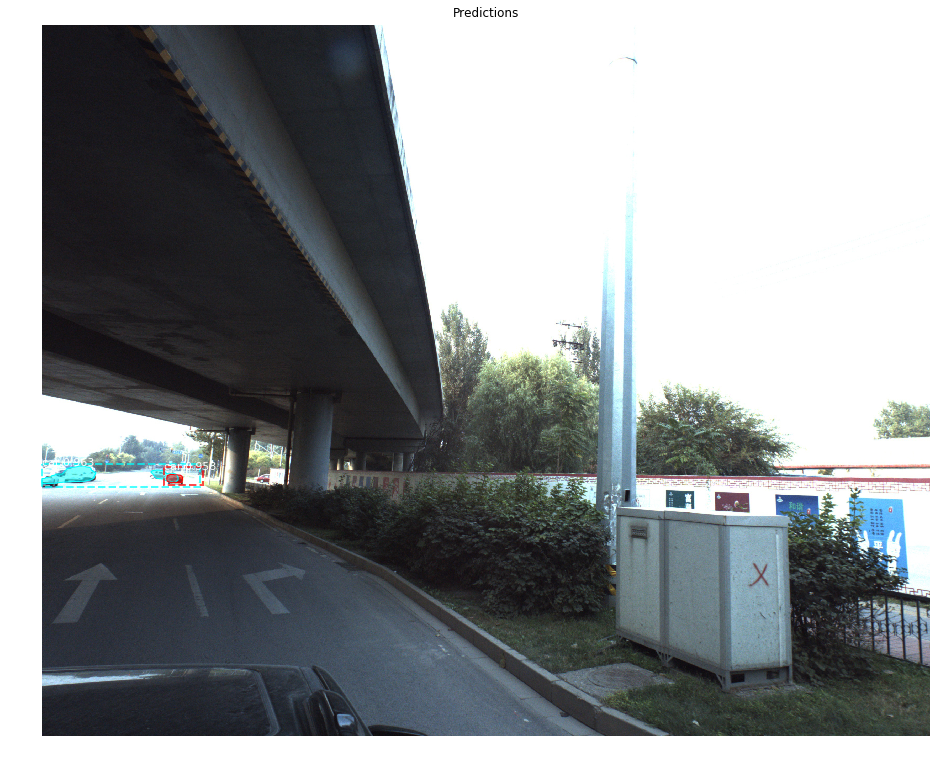

In [37]:
image_id = random.choice(dataset.image_ids)
#image, image_meta, gt_class_id, gt_bbox, gt_mask =\
#    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
image = dataset.load_image(image_id)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")

## Color Splash

This is for illustration. You can call `wad_tools.py` with the `splash` option to get better images without the black padding.

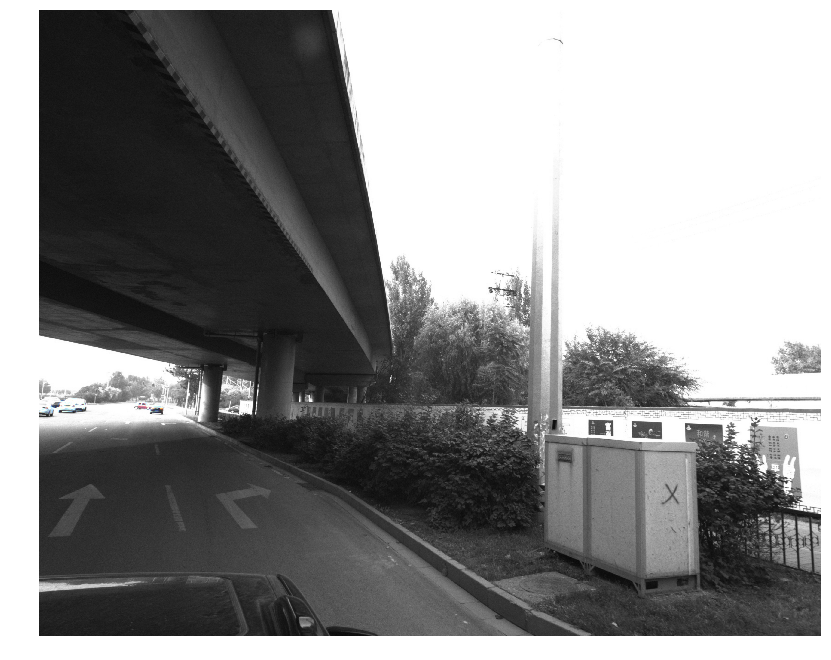

In [38]:
splash = wad_tools.color_splash(image, r['masks'])
display_images([splash], cols=1)

In [39]:
r["masks"].shape

(2710, 3384, 2)

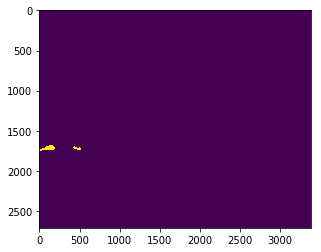

In [40]:
plt.imshow(r["masks"][:,:,0]*255)

## Get all Test Predictions

In [23]:
from tqdm import *

preds_test=np.array([dict() for _ in dataset.image_ids])

for i, image_id in tqdm(enumerate(dataset.image_ids), total=len(dataset.image_ids), unit="images"):
  image = dataset.load_image(image_id)
  info = dataset.image_info[image_id]
  #print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
  #                                     dataset.image_reference(image_id)))

  # Run object detection
  results = model.detect([image], verbose=0)
  preds_test[i]['id']=info["id"]
  preds_test[i]['image']=image
  mask = (np.sum(results[0]["masks"], -1, keepdims=True) >= 1) 
  preds_test[i]['pred']=np.squeeze(mask)
  #print(preds_test[i]['pred'].shape)
  
  

  3%|▎         | 58/1917 [09:10<4:53:58,  9.49s/images]

KeyboardInterrupt: 

In [42]:
np.save('preds_test', preds_test)

# Encode and submit our results

Now it's time to submit our results. I've stolen [this](https://www.kaggle.com/rakhlin/fast-run-length-encoding-python) excellent implementation of run-length encoding.

## Step by Step Prediction

In [43]:
from skimage.morphology import label
def rle_encoding(x):
    """ Run-length encoding from 
    https://www.kaggle.com/kmader/opencv-hog-submission/code based on
    https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
    Modified by Konstantin, https://www.kaggle.com/lopuhin
    """
    assert x.dtype == np.bool
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.append([b, 0])
        run_lengths[-1][1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

Let's iterate over the test IDs and generate run-length encodings for each seperate mask identified by skimage ...

In [1]:
new_test_ids = []
rles = []
for n, id_ in enumerate(dataset.image_ids):
    print("shape:", n, preds_test[n]["pred"].shape, preds_test[n]["image"].shape)
    #imshow((X_test[n]*tstd+tmean)*255)
    #plt.show()
    #imshow(preds_test_upsampled[n])
    #plt.show()
    rle = list(prob_to_rles(preds_test[n]["pred"]))
    rles.extend(rle)
    new_test_ids.extend([preds_test[n]["id"]] * len(rle))

NameError: name 'dataset' is not defined

... and then finally create our submission!

In [ ]:
print(rles[1])

In [0]:
from google.colab import files
import pandas as pd
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))

#save as a csv file
sub.to_csv(os.path.join(ROOT_DIR, 'samples/wad', 'sub-dsbowl2018_mask_rcnn_test2.csv'), index=False)



In [ ]:
!ls